Date: 2016-10-3

The goal of this notebook is to build code for ripple classification.

- Find place cells
    - plot linear distance vs. firing rate
- Build a model of position and decode position
    - figure out linear position structure
    - plot posterior density vs. time (movie?)
    - use both glm with spline for position and gaussian kernel model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

sys.path.append('../src/')
import data_processing

## Find place cells

### Get spikes

In [445]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = data_processing.make_epochs_dataframe(animals, days)
tetrode_info = data_processing.make_tetrode_dataframe(animals)
epoch_keys = (epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'].index)

cur_tetrode_info = pd.concat([tetrode_info[key] for key in epoch_keys])
cur_tetrode_info

area  depth descrip  numcells tetrode_id
animal day epoch_ind tetrode_number                                          
HPa    8   2         1                CA1    113  riptet        12     HPa821
                     2                CA1    121     NaN         0     HPa822
                     3                CA1     90  CA1Ref         0     HPa823
                     4                CA1    116  riptet        15     HPa824
                     5                CA1    116  riptet         0     HPa825
                     6                CA1    110  riptet         0     HPa826
                     7                CA1    114  riptet         0     HPa827
                     8               iCA1    114  riptet         0     HPa828
                     9               iCA1    100  riptet         0     HPa829
                     10              iCA1     96     NaN         0    HPa8210
                     11              iCA1    106  riptet         0    HPa8211
                     12              iCA1    114  riptet         3    HPa8212
                     13              iCA1    120     NaN         0    HPa8213
                     14              iCA1    105  riptet         6    HPa8214
                     15               PFC     93     NaN         0    HPa8215
                     16               PFC     90     NaN         0    HPa8216
                     17               PFC     90     NaN         6    HPa8217
                     18               PFC     90     NaN         0    HPa8218
                     19               PFC    130     NaN         0    HPa8219
                     20               PFC    109     NaN         0    HPa8220

In [3]:
neuron_info = data_processing.make_neuron_dataframe(animals)
cur_neuron_info = (pd.concat([neuron_info[key] for key in epoch_keys])
    .dropna()
    .query('(numspikes > 0) & (area == "CA1")'))
cur_neuron_info

area                   csi  \
animal day epoch_ind tetrode_number neuron_number                              
HPa    8   2         1              2              CA1   0.05963302752293578   
                                    3              CA1   0.19162790697674417   
                                    4              CA1   0.08121019108280254   
                                    5              CA1   0.14817320703653586   
                                    6              CA1    0.1690929451287794   
                                    7              CA1  0.053475935828877004   
                     4              1              CA1   0.09773936170212766   
                                    2              CA1   0.13846153846153847   
                                    3              CA1    0.1411764705882353   
                                    4              CA1   0.11428571428571428   
                                    5              CA1   0.04081632653061224   
                                    6              CA1   0.02981651376146789   
                                    7              CA1   0.16352201257861634   
                                    8              CA1   0.16104868913857678   

                                                              meanrate  \
animal day epoch_ind tetrode_number neuron_number                        
HPa    8   2         1              2               0.7218543046357616   
                                    3               0.8899006622516556   
                                    4               0.5198675496688742   
                                    5                2.447019867549669   
                                    6               0.7392384105960265   
                                    7              0.15480132450331127   
                     4              1               1.2450331125827814   
                                    2               1.1837748344370862   
                                    3               0.7740066225165563   
                                    4              0.23178807947019867   
                                    5              0.20281456953642385   
                                    6               0.3609271523178808   
                                    7               0.1316225165562914   
                                    8              0.22102649006622516   

                                                  numspikes  \
animal day epoch_ind tetrode_number neuron_number             
HPa    8   2         1              2                   872   
                                    3                  1075   
                                    4                   628   
                                    5                  2956   
                                    6                   893   
                                    7                   187   
                     4              1                  1504   
                                    2                  1430   
                                    3                   935   
                                    4                   280   
                                    5                   245   
                                    6                   436   
                                    7                   159   
                                    8                   267   

                                                            propbursts  \
animal day epoch_ind tetrode_number neuron_number                        
HPa    8   2         1              2               0.2305045871559633   
                                    3               0.6409302325581395   
                                    4               0.3200636942675159   
                                    5               0.4983085250338295   
                                    6               0.5442329227323628   
                                    7              0.2085

### Get linear position

In [4]:
def get_linear_position_structure(epoch_key, animals, trajectory_category=None):
    animal, day, epoch = epoch_key
    struct = data_filter.get_data_structure(animals[animal], day, 'linpos', 'linpos')[epoch - 1][0][0]['statematrix']
    include_fields = ['time', 'traj', 'lindist']
    new_names = {'time': 'time', 'traj': 'trajectory_category_ind', 'lindist': 'linear_distance'}
    return (pd.DataFrame({new_names[name]: struct[name][0][0].flatten() for name in struct.dtype.names
                         if name in include_fields})
            .set_index('time')
            )


get_linear_position_structure(epoch_keys[0], animals)

linear_distance  trajectory_category_ind
time                                               
2713.0249         0.000000                        0
2713.0582         0.000000                        0
2713.0916         0.000000                        0
2713.1249         0.000000                        0
2713.1583         0.000000                        0
2713.1916         0.000000                        0
2713.2249         0.000000                        0
2713.2582         0.000000                        0
2713.2916         0.000000                        0
2713.3249         0.000000                        0
2713.3583         0.000000                        0
2713.3916         0.000000                        0
2713.4255         0.000000                        0
2713.4589         0.000000                        0
2713.4922         0.000000                        0
2713.5256         0.000000                        0
2713.5589         0.000000                        0
2713.5922         0.000000                        0
2713.6255         0.000000                        0
2713.6589         0.000000                        0
2713.6922         0.000000                        0
2713.7256         0.000000                        0
2713.7589         0.000000                        0
2713.7922         0.000000                        0
2713.8255         0.000000                        0
2713.8589         0.000000                        0
2713.8922         0.000000                        0
2713.9256         0.000000                        0
2713.9589         0.000000                        0
2713.9922         0.000000                        0
...                    ...                      ...
3919.0282         0.529825                        2
3919.0616         1.179825                        2
3919.0949         1.179825                        2
3919.1282         1.179825                        2
3919.1615         1.179825                        2
3919.1949         1.179825                        2
3919.2282         1.179825                        2
3919.2616         1.179825                        2
3919.2949         1.179825                        2
3919.3282         1.179825                        2
3919.3615         1.179825                        2
3919.3949         1.829825                        2
3919.4282         1.829825                        2
3919.4616         1.829825                        2
3919.4949         1.179825                        2
3919.5282         1.179825                        2
3919.5616         1.829825                        2
3919.5949         1.179825                        2
3919.6283         1.829825                        2
3919.6623         1.179825                        2
3919.6955         1.179825                        2
3919.7289         1.179825                        2
3919.7622         1.179825                        2
3919.7956         1.179825                        2
3919.8289         1.829825                        2
3919.8623         1.829825                        2
3919.8955         1.829825                        2
3919.9289         1.829825                        2
3919.9622         1.829825                        2
3919.9956         1.179825                        2

[36181 rows x 2 columns]

In [5]:
trajectory_direction = {0: np.nan, 1: 'Outbound', 2: 'Inbound', 3: 'Outbound', 4: 'Inbound'}
trajectory_turn = {0: np.nan, 1: 'Left', 2: 'Right', 3: 'Left', 4: 'Right'}
def linear_position(df):
    is_left_arm = (df.trajectory_category_ind == 1) | (df.trajectory_category_ind == 2)
    return np.where(is_left_arm, -1 * df.linear_distance, df.linear_distance)
        
position = (pd.concat([get_linear_position_structure(epoch_keys[0], animals),
                      data_filter.get_position_dataframe(epoch_keys[0], animals)], axis=1)
           .assign(trajectory_direction=lambda x: x.trajectory_category_ind.map(trajectory_direction))
           .assign(trajectory_turn=lambda x: x.trajectory_category_ind.map(trajectory_turn))
           .assign(trial_number=lambda x: np.cumsum(x.trajectory_category_ind.diff().fillna(0) > 0) + 1)
           .assign(linear_position=linear_position)
           )
position

linear_distance  trajectory_category_ind  x_position  y_position  \
time                                                                          
2713.0249         0.000000                        0         NaN         NaN   
2713.0582         0.000000                        0         NaN         NaN   
2713.0916         0.000000                        0       97.50      106.60   
2713.1249         0.000000                        0       96.20      105.95   
2713.1583         0.000000                        0       96.20      105.95   
2713.1916         0.000000                        0       96.20      105.95   
2713.2249         0.000000                        0       96.20      105.95   
2713.2582         0.000000                        0       96.20      105.95   
2713.2916         0.000000                        0       96.20      105.95   
2713.3249         0.000000                        0       96.20      105.30   
2713.3583         0.000000                        0       96.20      105.30   
2713.3916         0.000000                        0       96.20      105.30   
2713.4255         0.000000                        0       96.20      105.95   
2713.4589         0.000000                        0       96.20      105.95   
2713.4922         0.000000                        0       96.20      105.95   
2713.5256         0.000000                        0       96.20      105.95   
2713.5589         0.000000                        0       96.20      105.95   
2713.5922         0.000000                        0       96.20      105.30   
2713.6255         0.000000                        0       96.20      105.30   
2713.6589         0.000000                        0       96.20      105.30   
2713.6922         0.000000                        0       96.20      105.30   
2713.7256         0.000000                        0       96.20      105.30   
2713.7589         0.000000                        0       96.20      105.30   
2713.7922         0.000000                        0       96.20      105.30   
2713.8255         0.000000                        0       95.55      105.30   
2713.8589         0.000000                        0       95.55      105.30   
2713.8922         0.000000                        0       95.55      105.30   
2713.9256         0.000000                        0       96.20      105.30   
2713.9589         0.000000                        0       96.20      105.30   
2713.9922         0.000000                        0       96.20      105.95   
...                    ...                      ...         ...         ...   
3919.0282         0.529825                        2      102.70      101.40   
3919.0616         1.179825                        2      102.70      100.75   
3919.0949         1.179825                        2      103.35      100.75   
3919.1282         1.179825                        2      103.35      100.75   
3919.1615         1.179825                        2      102.70      100.75   
3919.1949         1.179825                        2      102.70      100.75   
3919.2282         1.179825                        2      102.70      100.75   
3919.2616         1.179825                        2      102.70      100.75   
3919.2949         1.179825                        2      102.70      100.75   
3919.3282         1.179825                        2      103.35      100.75   
3919.3615         1.179825                        2      103.35      100.75   
3919.3949         1.829825                        2      103.35      100.10   
3919.4282         1.829825                        2      103.35      100.10   
3919.4616         1.829825                        2      103.35      100.10   
3919.4949         1.179825                        2      103.35      100.75   
3919.5282         1.179825                        2      103.35      100.75   
3919.5616         1.829825                        2      103.35      100.10   
3919.5949         1.179825                        2      103.

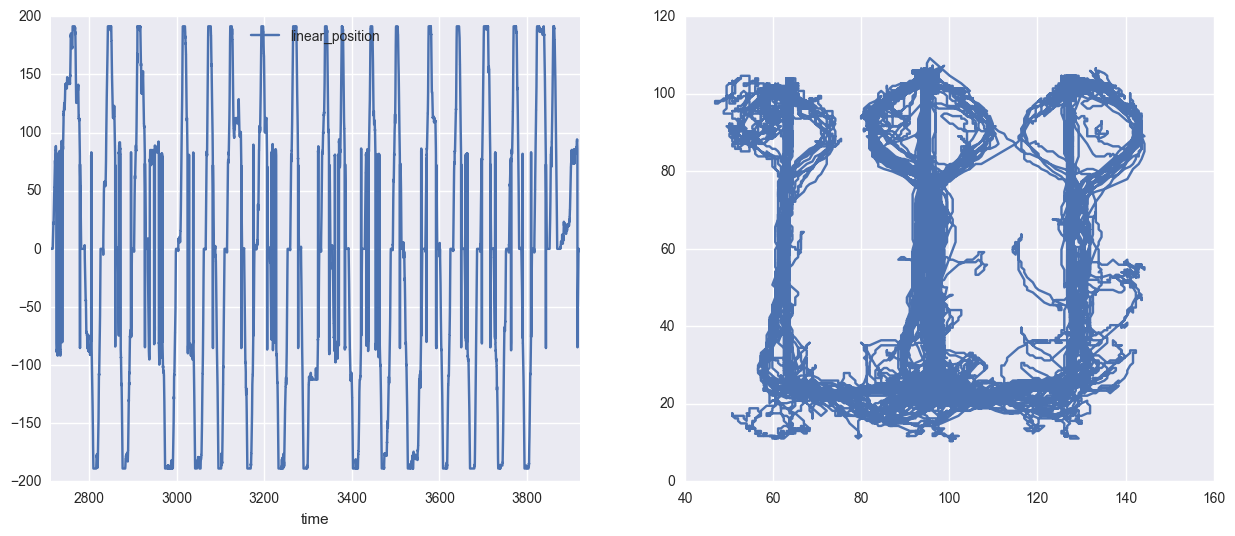

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
position.plot(y='linear_position', ax=axes[0])
axes[1].plot(position.x_position, position.y_position)

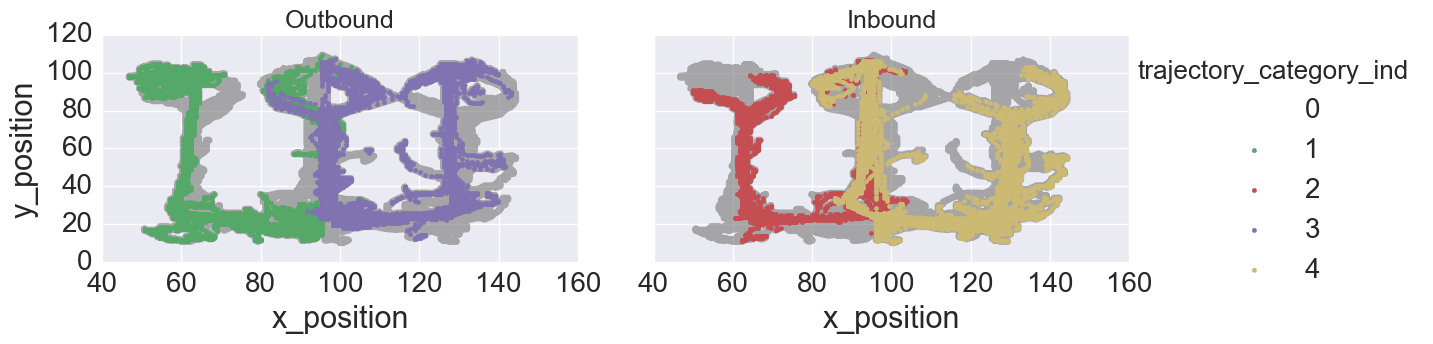

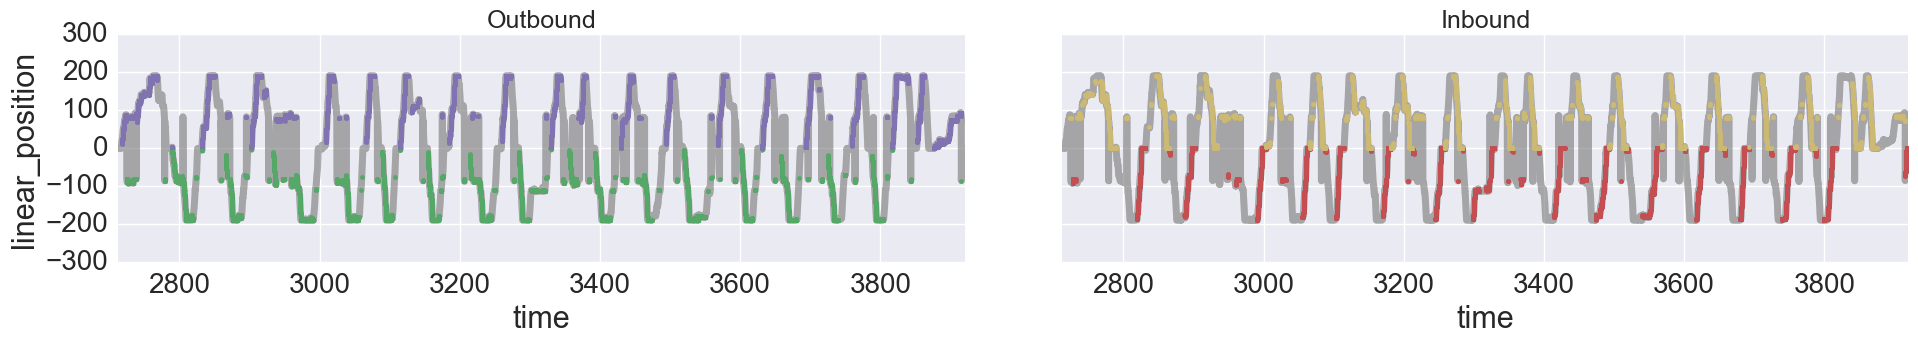

In [7]:
def scatter_wrap(x, y, df, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    ax.plot(df[x], df[y], color='grey', zorder=1, linewidth=5, alpha=0.4)
    ax.scatter(data[x], data[y], **kwargs, zorder=2, s=10)

sns.set(font_scale=2)
grid = sns.FacetGrid(position, col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=1.5)
grid.map_dataframe(scatter_wrap, 'x_position', 'y_position', position)
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
grid.add_legend()

grid = sns.FacetGrid(position.reset_index(), col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=2.5)
grid.map_dataframe(scatter_wrap, 'time', 'linear_position', position.reset_index())
grid.set(xlim=(position.index.min(), position.index.max()))
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


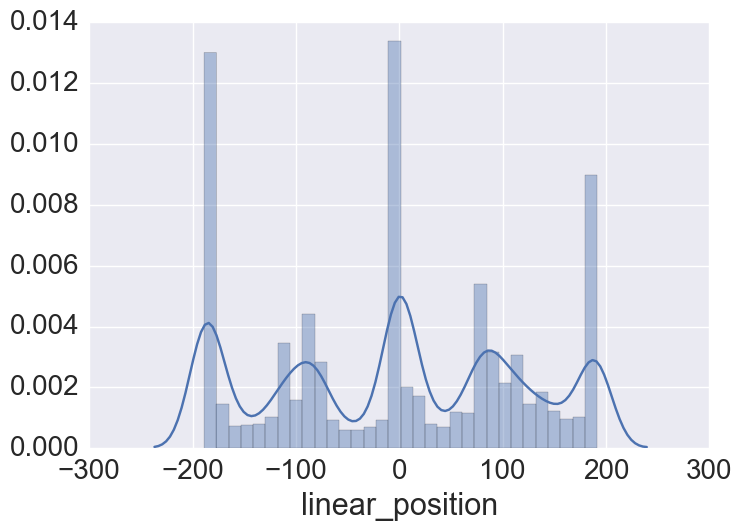

In [8]:
sns.distplot(position.linear_position)

### Combine cell spike data with linear position and trial time

In [9]:
def get_trial_time(neuron_key, animals):
    animal, day, epoch, tetrode_number, _ = neuron_key
    lfp_df = data_filter._get_LFP_dataframe((animal, day, epoch, tetrode_number), animals)
    return lfp_df.index

time = get_trial_time(cur_neuron_info.index[0], animals)
time

Float64Index([    2712.9948, 2712.99546667, 2712.99613333,     2712.9968,
              2712.99746667, 2712.99813333,     2712.9988, 2712.99946667,
              2713.00013333,     2713.0008,
              ...
                  3920.0068, 3920.00746667, 3920.00813333,     3920.0088,
              3920.00946667, 3920.01013333,     3920.0108, 3920.01146667,
              3920.01213333,     3920.0128],
             dtype='float64', name='time', length=1810528)

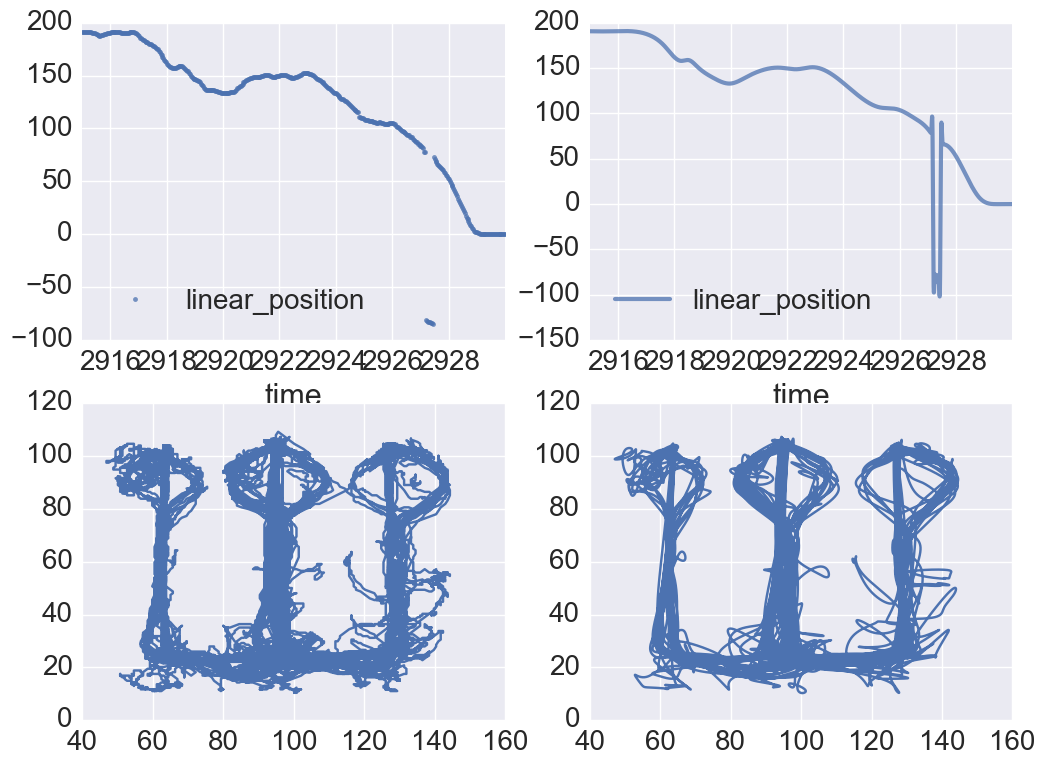

In [10]:
time = get_trial_time(cur_neuron_info.index[0], animals)
spikes_df = data_filter.get_spikes_dataframe(cur_neuron_info.index[0], animals)
spikes_df.index = time[data_filter.find_closest_ind(time, spikes_df.index.values)]
spikes_df = spikes_df.reindex(index=time, fill_value=0)
categorical_columns = ['trajectory_category_ind', 'trajectory_turn', 'trajectory_direction', 'trial_number']
continuous_columns = ['head_direction', 'speed', 'linear_distance', 'linear_position']
continuous_2D_columns = ['x_position', 'y_position']
position_categorical = (position
                        .drop(continuous_columns, axis=1)
                        .drop(continuous_2D_columns, axis=1))
position_categorical = position_categorical.reindex(index=time, method='pad')
position_continuous = (position
                       .drop(categorical_columns, axis=1)
                       .drop(continuous_2D_columns, axis=1)
                       .dropna())
position_continuous_2D = (position
                       .drop(categorical_columns, axis=1)
                       .drop(continuous_columns, axis=1)
                       .dropna())
interpolated_position = (pd.concat([position_continuous, spikes_df])
                         .drop('is_spike', axis=1)
                         .sort_index()
                         .interpolate(method='spline', order=3)
                         .reindex(index=time)
                        )
interpolated_position_2D = (pd.concat([position_continuous_2D, spikes_df])
                         .drop('is_spike', axis=1)
                         .sort_index()
                         .interpolate(method='spline', order=3)
                         .reindex(index=time)
                        )
spikes_position = (pd.concat([spikes_df, position_categorical, interpolated_position, interpolated_position_2D], axis=1)
                   .fillna(method='backfill'))
fig, ax = plt.subplots(2, 2, figsize=(12,9))
position.loc[2915:2930].plot(y='linear_position', ax=ax[0,0], style='.', alpha=0.75)
spikes_position.loc[2915:2930].plot(y='linear_position', ax=ax[0,1], linewidth=3, alpha=0.75)
ax[1,0].plot(position.x_position, position.y_position)
ax[1,1].plot(spikes_position.x_position, spikes_position.y_position)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


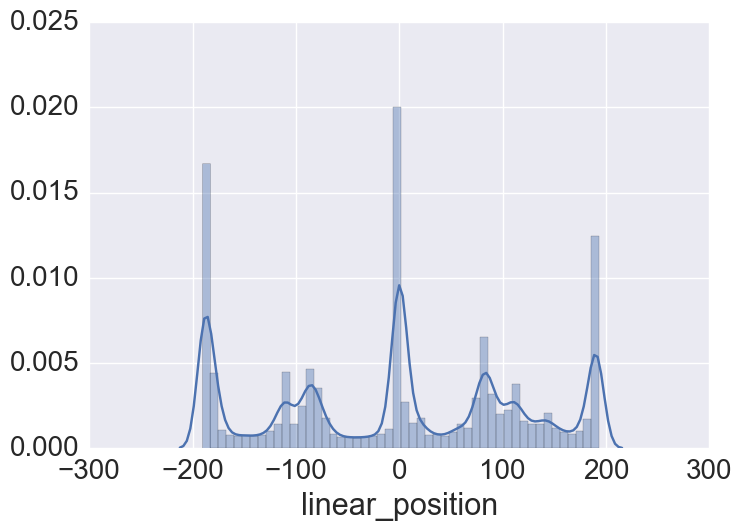

In [11]:
sns.distplot(spikes_position.linear_position)

Demonstrate interpolation makes sense by showing the place fields

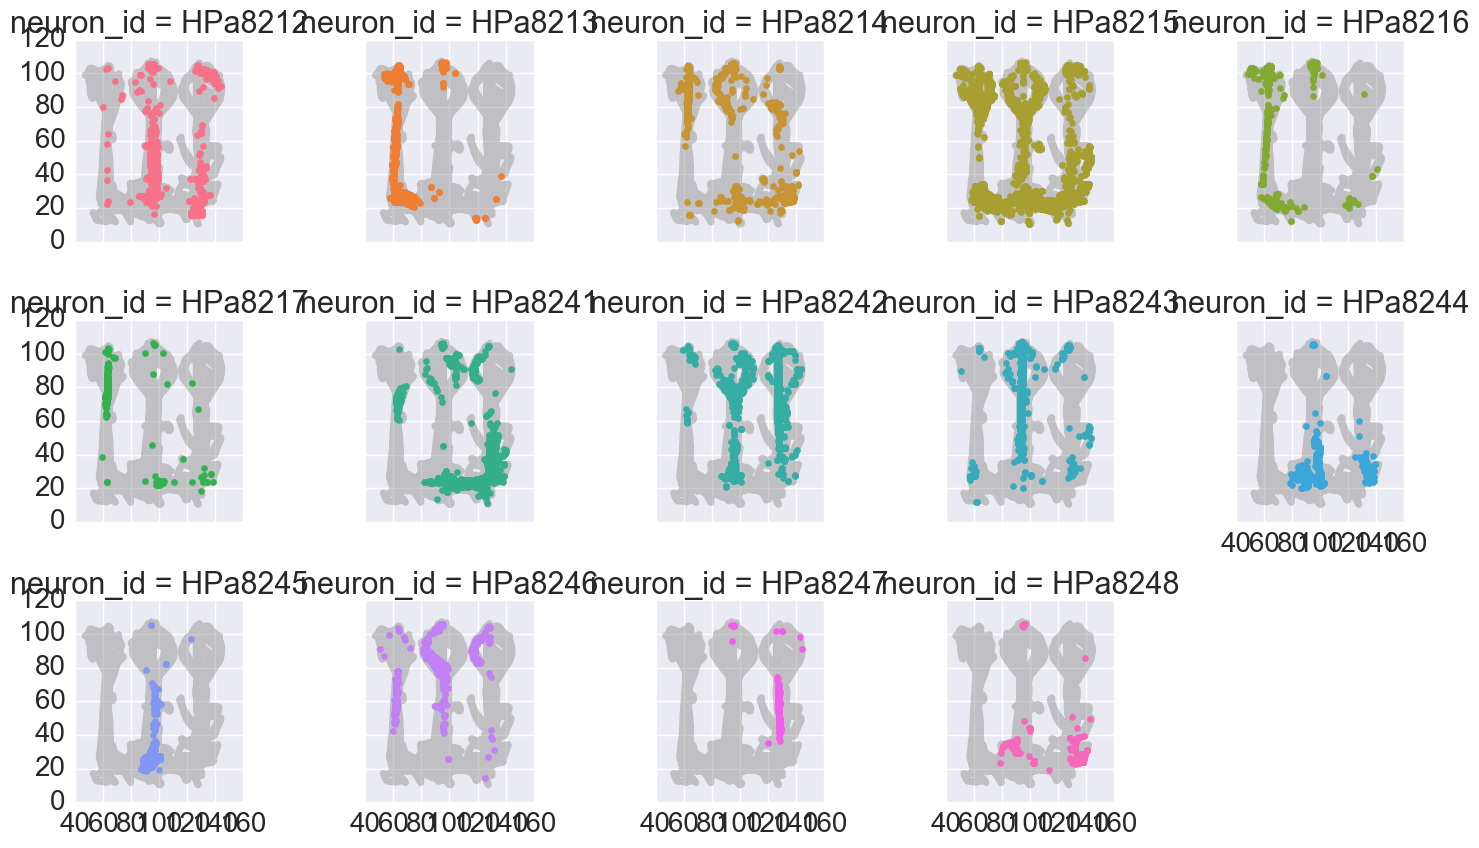

In [461]:
def transform_spikes(neuron_index, animals):
    time = get_trial_time(neuron_index, animals)
    spikes_df = data_filter.get_spikes_dataframe(neuron_index, animals)
    spikes_df.index = time[data_filter.find_closest_ind(time, spikes_df.index.values)]
    return spikes_df.reindex(index=time, fill_value=0)


spikes_data = [transform_spikes(neuron_index, animals)
               for neuron_index in cur_neuron_info.index]

interpolated_positions = (pd.concat([position_categorical, interpolated_position, interpolated_position_2D],
                                    axis=1)
                          .fillna(method='backfill'))

# spikes_df = pd.concat(spikes_data, axis=1, keys=cur_neuron_info.neuron_id)
# spikes_position_df = pd.concat([interpolated_positions, spikes_df], axis=1)

# spikes_position_df[spikes_position_df[('HPa8212', 'is_spike')] == 1].linear_position

def plot_place_fields(**kwargs):
    data = kwargs.pop('data')
    df = kwargs.pop('df')
    ax = plt.gca()
    ax.plot(df.x_position, df.y_position, color='grey', zorder=1, linewidth=5, alpha=0.4)
    plt.scatter(data.query('is_spike == 1').x_position,
                  data.query('is_spike == 1').y_position,
                  **kwargs, zorder=2)

spikes_df = pd.concat(spikes_data, axis=0, keys=cur_neuron_info.neuron_id, names=['neuron_id', 'time'])
spikes_position_df = interpolated_positions.join(spikes_df, how='inner')


grid = sns.FacetGrid(spikes_position_df.reset_index(), col='neuron_id', col_wrap=5, hue='neuron_id')
grid.map_dataframe(plot_place_fields, df=interpolated_positions)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


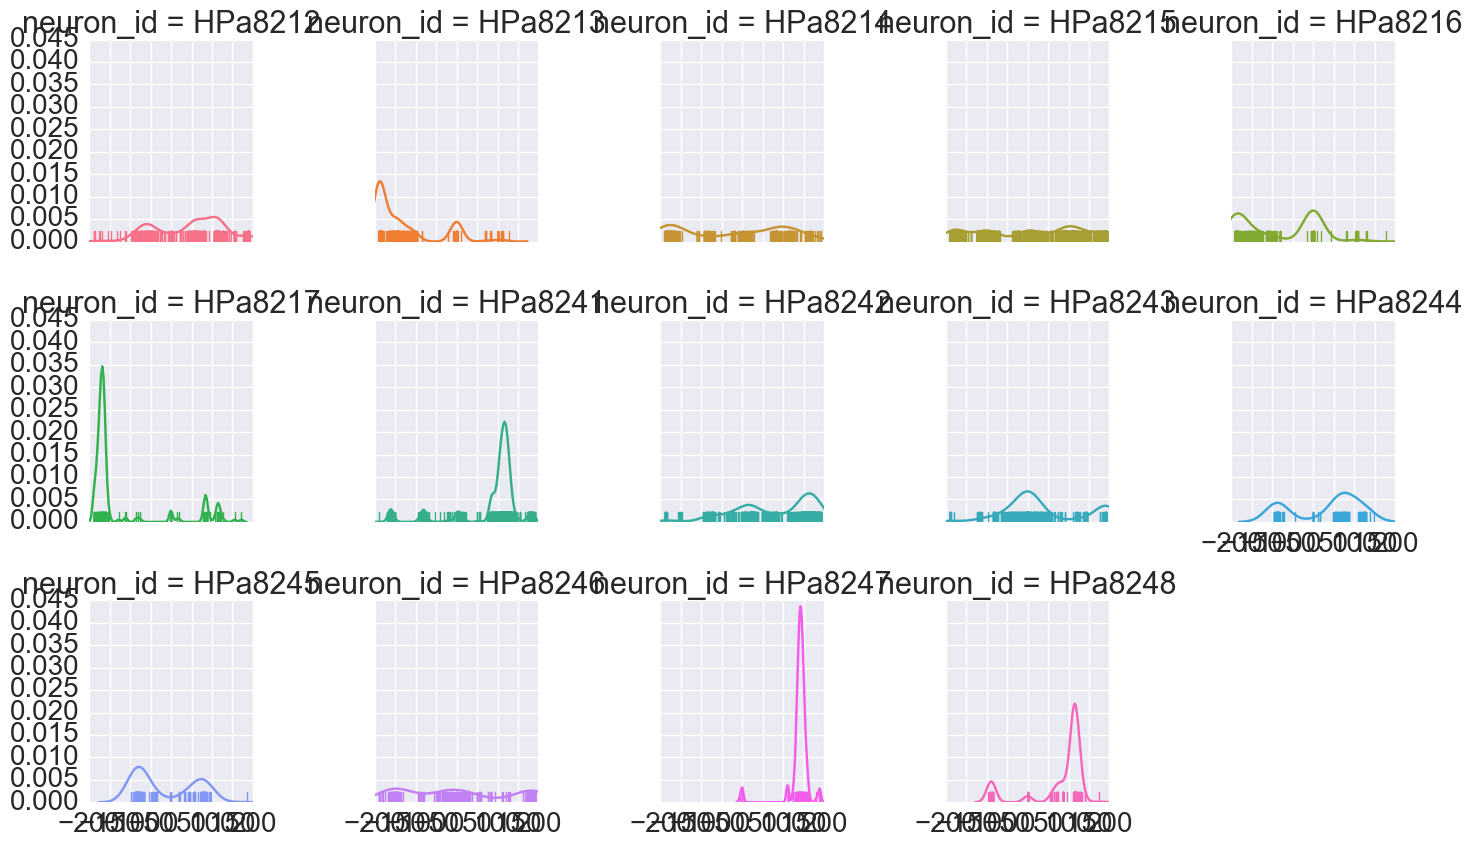

In [462]:
def plot_linear_place_fields(**kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    sns.distplot(data.query('is_spike == 1').linear_position, rug=True, hist=False, **kwargs)

grid = sns.FacetGrid(spikes_position_df.reset_index(), col='neuron_id', col_wrap=5, hue='neuron_id')
grid.map_dataframe(plot_linear_place_fields)
grid.set(xlim=(-200, 200))

### Fitting encoding model

We want to build a model that relates spiking activity to linear distance. We will then use this model to decode linear position.

#### Simple Poisson GLM
We can fit a glm using statsmodel

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
fit = smf.glm(formula='is_spike ~ linear_position', data=spikes_position, family=sm.families.Poisson()).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_spike   No. Observations:              1810528
Model:                            GLM   Df Residuals:                  1810526
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -7463.8
Date:                Tue, 25 Oct 2016   Deviance:                       13184.
Time:                        12:34:52   Pearson chi2:                 1.74e+06
No. Iterations:                    13                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -7.7096      0.036   -212.263      0.000        -7.781    -7.638
linear_position     0.0033      0.000     11.436      0.000         0.003     0.004
===================================================================================
"""

#### More complicated GLM with splines
A regular GLM can fit a single slope to the linear distance covariate, but for a place cell the rate varies by linear position.

**Note: the patsy design matrix puts spline knots as quantiles unless otherwise specified

In [15]:
import patsy
formula = 'is_spike ~ 1 + bs(linear_position, df=10, degree=3)';
response, design_matrix = patsy.dmatrices(formula, spikes_position, return_type='dataframe')
fit = sm.GLM(response, design_matrix, family=sm.families.Poisson()).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_spike   No. Observations:              1810528
Model:                            GLM   Df Residuals:                  1810517
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6947.4
Date:                Tue, 25 Oct 2016   Deviance:                       12151.
Time:                        12:35:48   Pearson chi2:                 1.93e+06
No. Iterations:                    13                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -10.9523      1.567     -6.987      0.000       -14.025    -7.880
bs(linear_position, df=10, degree=3)[0]    -0.6250      2.225     -0.281      0.779        -4.986     3.736
bs(linear_position, df=10, degree=3)[1]     3.1302      1.639      1.909      0.056        -0.083     6.343
bs(linear_position, df=10, degree=3)[2]    -2.5663      1.695     -1.514      0.130        -5.889     0.756
bs(linear_position, df=10, degree=3)[3]     8.7130      1.561      5.582      0.000         5.654    11.772
bs(linear_position, df=10, degree=3)[4]    -0.5675      1.595     -0.356      0.722        -3.694     2.559
bs(linear_position, df=10, degree=3)[5]     6.5884      1.575      4.183      0.000         3.501     9.676
bs(linear_position, df=10, degree=3)[6]     2.0739      1.585      1.309      0.191        -1.032     5.180
bs(linear_position, df=10, degree=3)[7]     6.0850      1.598      3.809      0.000         2.954     9.216
bs(linear_position, df=10, degree=3)[8]     0.0933      1.678      0.056      0.956        -3.195     3.382
bs(linear_position, df=10, degree=3)[9]     3.4289      1.586      2.162      0.031         0.321     6.537
===========================================================================================================
"""

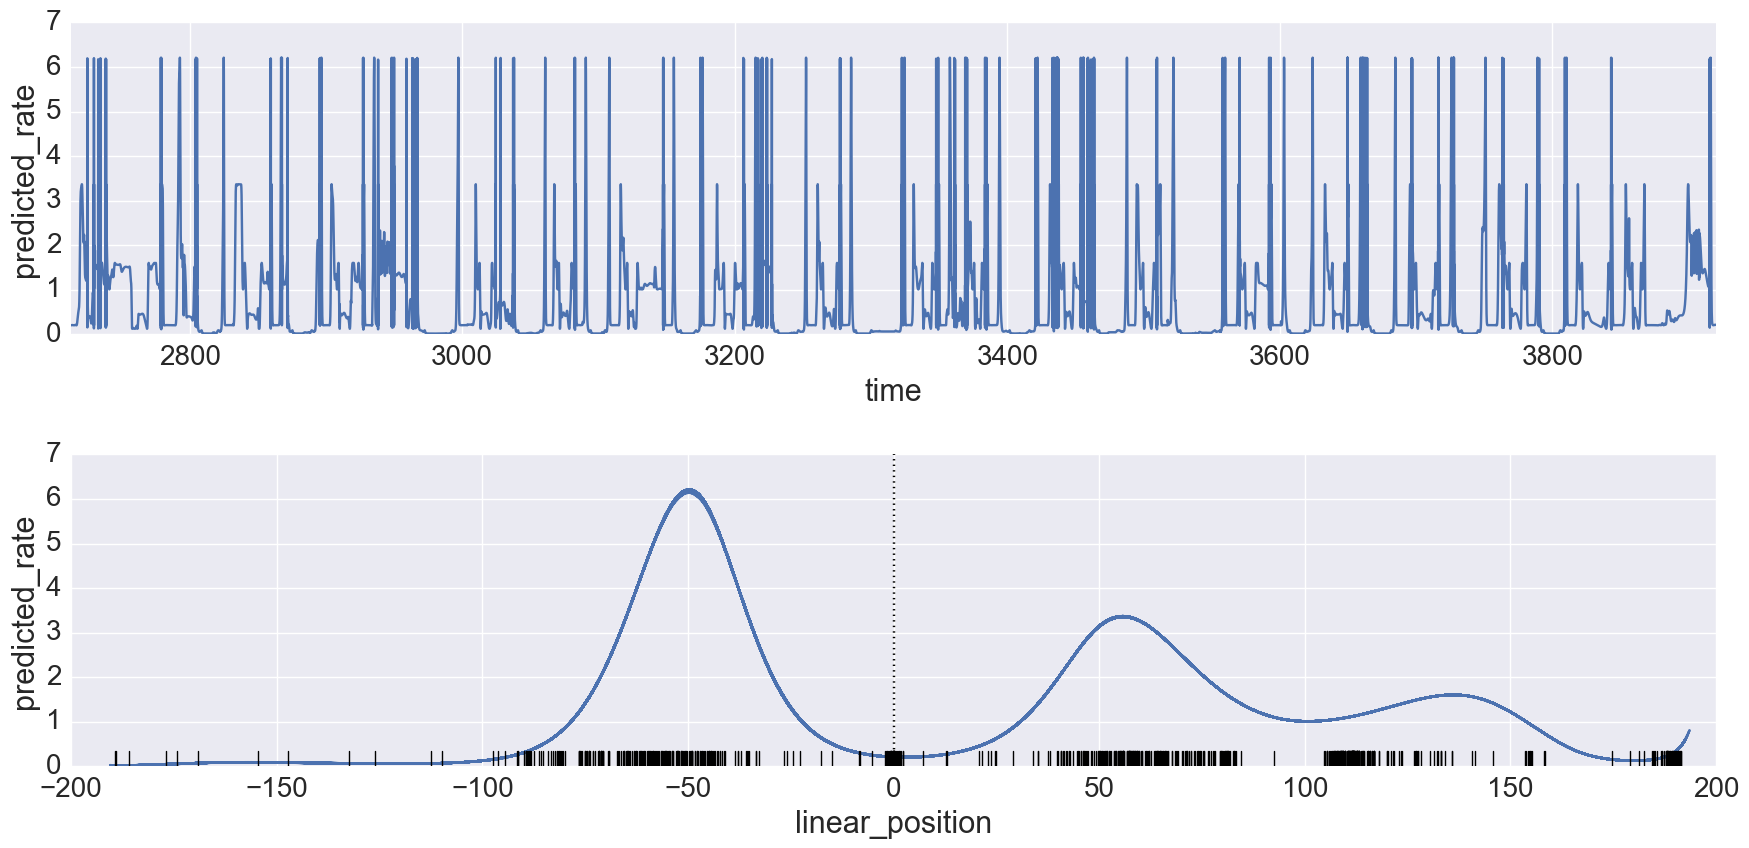

In [16]:
fig, ax = plt.subplots(2, figsize=(18,9))
sampling_frequency = 1500
predicted = pd.concat([pd.DataFrame({'predicted_rate': fit.predict(design_matrix) * sampling_frequency})
             .set_index(spikes_position.index.values), spikes_position], axis=1)
predicted.plot(y='predicted_rate', ax=ax[0], legend=False)
ax[0].set_ylabel('predicted_rate')
ax[0].set_xlabel('time')
ax[1].plot(predicted.linear_position, predicted.predicted_rate)
ax[1].set_xlabel('linear_position')
ax[1].set_ylabel('predicted_rate')
ax[1].set_xlim((-200, 200))
sns.rugplot(predicted.query('is_spike == 1').linear_position, ax=ax[1], color='black')
ax[1].axvline(0, color='black', linestyle=':')
plt.tight_layout()

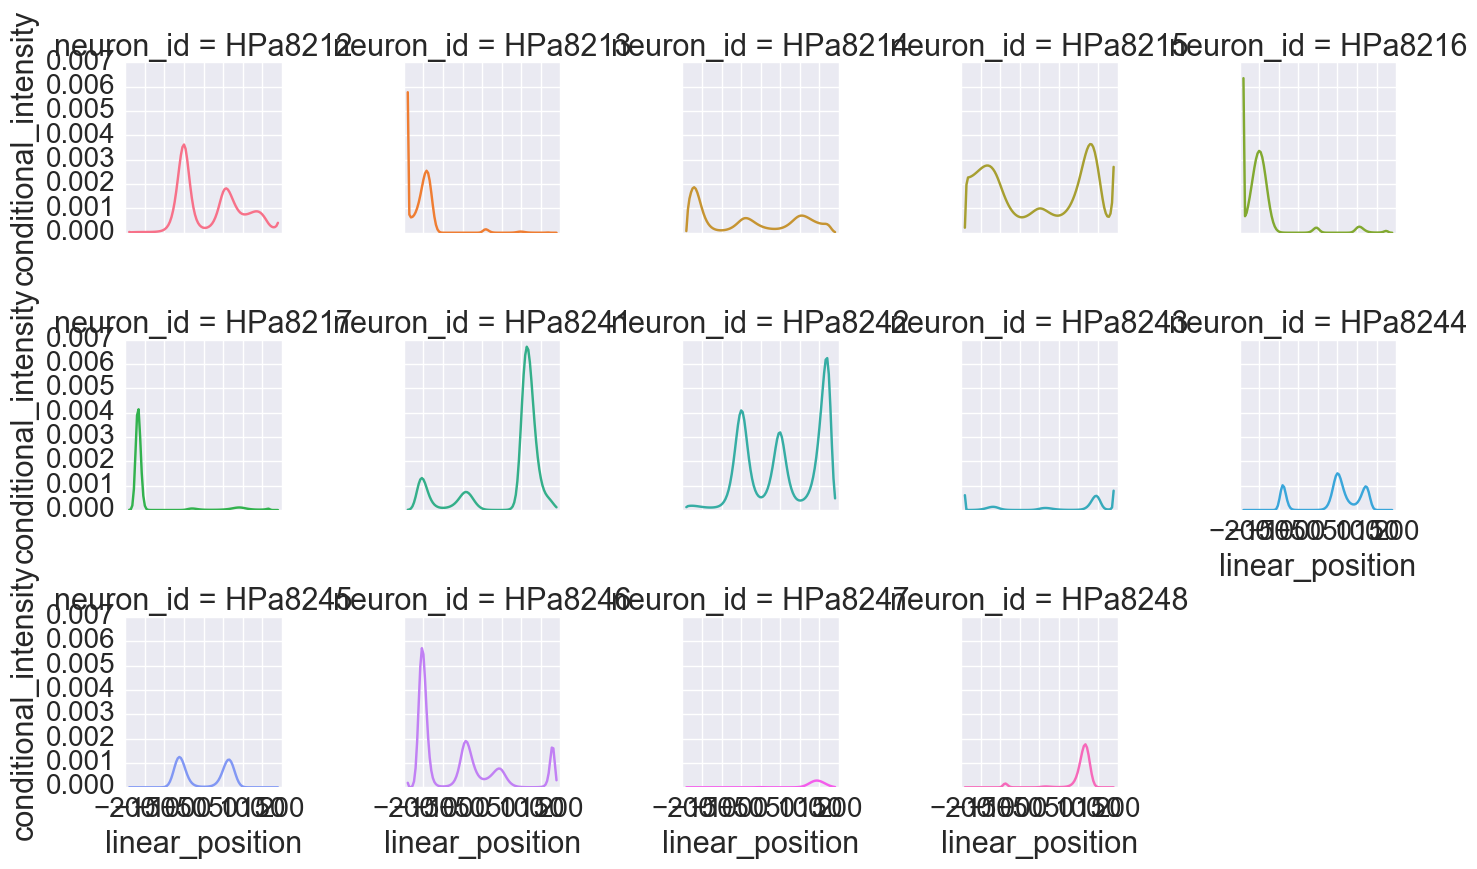

In [17]:
spikes_data = [transform_spikes(neuron_index, animals)
               for neuron_index in cur_neuron_info.index]
interpolated_positions = (pd.concat([position_categorical, interpolated_position, interpolated_position_2D], axis=1)
                          .fillna(method='backfill'))
formula = '1 + bs(linear_position, df=10, degree=3)';
design_matrix = patsy.dmatrix(formula, interpolated_positions, return_type='dataframe')

# Encode Fit on half of the data
half_data_ind = int(np.fix(len(design_matrix) / 2))

fit = [sm.GLM(neuron_spikes.iloc[0:half_data_ind], design_matrix.iloc[0:half_data_ind],
              family=sm.families.Poisson()).fit()
       for neuron_spikes in spikes_data]

# Get conditional intensity by linear position
linear_position_grid = np.linspace(-192, 192, 97)
linear_position_grid_centers = linear_position_grid[:-1] + np.diff(linear_position_grid) / 2
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info],
                                                    {'linear_position': linear_position_grid_centers})[0]
conditional_intensity = np.vstack([fitted_model.predict(predict_design_matrix)
                                   for fitted_model in fit]).T

ci_df = pd.DataFrame(conditional_intensity, index=pd.Index(linear_position_grid_centers, name='linear_position'),
                     columns=cur_neuron_info.neuron_id).unstack().rename('conditional_intensity')

grid = sns.FacetGrid(ci_df.reset_index(), col='neuron_id', col_wrap=5, hue='neuron_id')
grid.map(plt.plot, 'linear_position', 'conditional_intensity')
grid.set(xlim=(-200, 200))

### Decoding
We now want to use the conditional intensity function from the encoding model (which relates position to spike rate) to decode (relate spikes to position)

#### Observation Model
The likelihood can be characterized by its conditional intensity function $\lambda_{t}$ at time t with time bin size $\Delta_{t}$ by the following equation:

$$p(spike_{t}\lvert x_{t}) \propto (\lambda_{t})^{spike_{t}}\exp^{-\lambda_{t}\Delta_{t}}$$

where $\lambda_{t}\Delta_{t}$ is the probability of there being a spike at time t and $\exp^{-\lambda_{t}\Delta_{t}}$ is the probability of there not being a spike at time t.

In [18]:
def instantaneous_poisson_likelihood(is_spike, conditional_intensity=None, time_bin_size=1):
    probability_spike = conditional_intensity
    probability_no_spike = np.exp(-conditional_intensity * time_bin_size)
    return (probability_spike ** is_spike) * probability_no_spike


def normalize_to_probability(distribution):
    '''Ensure the distribution integrates to 1
    so that it is a probability distribution
    '''
    return distribution / np.sum(distribution.flatten())


def combined_likelihood(data, likelihood_function=None, likelihood_args={}):
    try:
        return np.prod(likelihood_function(data, **likelihood_args), axis=1)
    except ValueError:
        return likelihood_function(data, **likelihood_args)

Test that the instantaneous likelihood function works and makes sense.

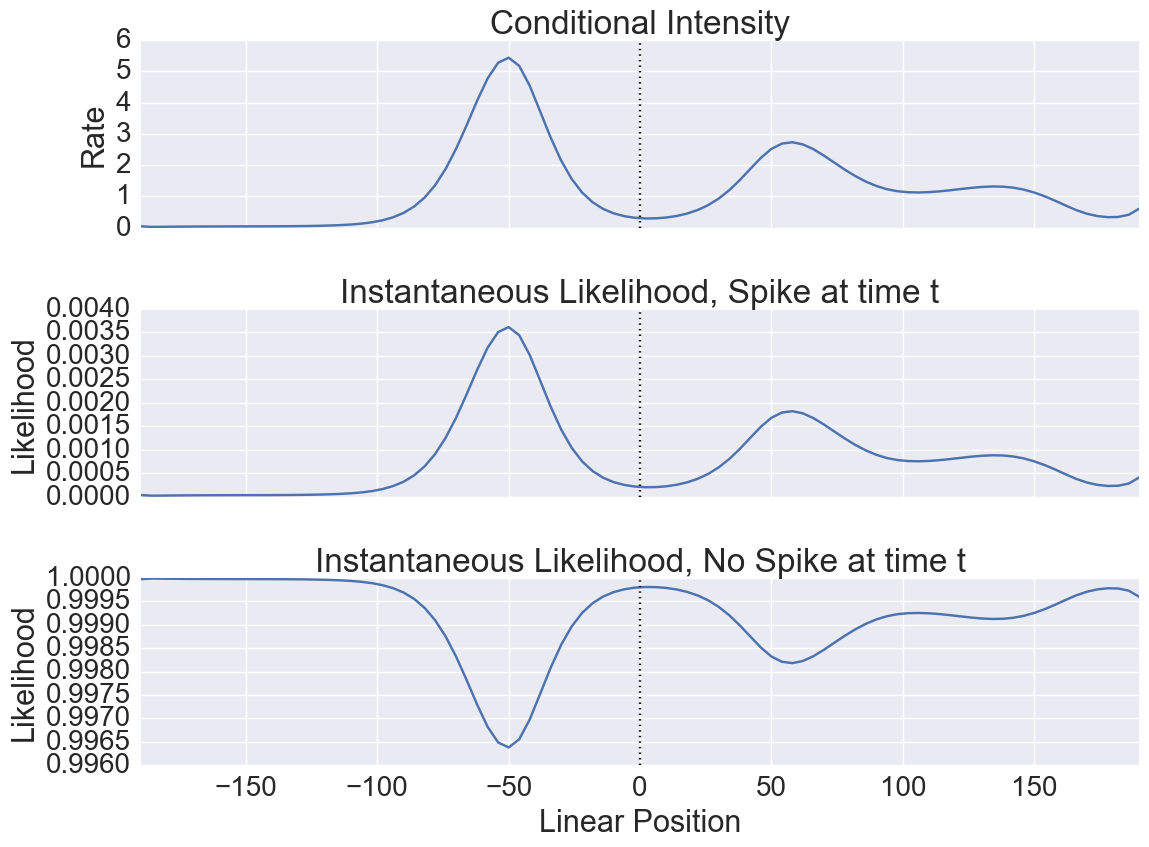

In [23]:
linear_position_grid = np.linspace(-192, 192, 97)
linear_position_grid_centers = linear_position_grid[:-1] + np.diff(linear_position_grid) / 2
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info],
                                                    {'linear_position': linear_position_grid_centers})[0]
predicted = fit[0].predict(predict_design_matrix)
fig, axes = plt.subplots(3, figsize=(12, 9), sharex=True)
axes[0].plot(linear_position_grid_centers, predicted * 1500)
axes[0].set_title('Conditional Intensity')
axes[0].set_ylabel('Rate')
axes[0].axvline(0, color='black', linestyle=':')

axes[1].plot(linear_position_grid_centers,
             instantaneous_poisson_likelihood(1, conditional_intensity=predicted))
axes[1].set_title('Instantaneous Likelihood, Spike at time t')
axes[1].set_ylabel('Likelihood')
axes[1].axvline(0, color='black', linestyle=':')

axes[2].plot(linear_position_grid_centers,
             instantaneous_poisson_likelihood(0, conditional_intensity=predicted)
            )
axes[2].set_title('Instantaneous Likelihood, No Spike at time t')
axes[2].set_xlabel('Linear Position')
axes[2].set_ylabel('Likelihood')
axes[2].set_xlim((linear_position_grid_centers.min(), linear_position_grid_centers.max()))
axes[2].axvline(0, color='black', linestyle=':')
plt.tight_layout()

Now test that combining the likelihood of multiple neurons works (in this case we use the estimates of the same neuron).

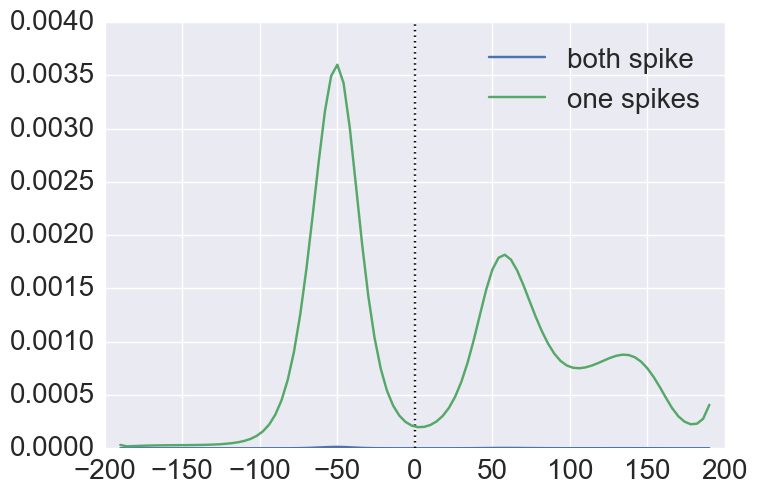

In [24]:
data = np.array([1, 1])
predicted2 = np.vstack((predicted, predicted)).T
likelihood_params = dict(conditional_intensity=predicted2)
likelihood = combined_likelihood(data, likelihood_function=instantaneous_poisson_likelihood,
                                 likelihood_args=likelihood_params)
plt.plot(linear_position_grid_centers, likelihood, label='both spike')
plt.axvline(0, color='black', linestyle=':')

data = np.array([0, 1])
likelihood_params = dict(conditional_intensity=predicted2)
likelihood = combined_likelihood(data, likelihood_function=instantaneous_poisson_likelihood,
                                 likelihood_args=likelihood_params)
plt.plot(linear_position_grid_centers, likelihood, label='one spikes')

# data = np.array([0, 0])
# likelihood_params = dict(conditional_intensity=predicted2, time_bin_size=time_bin_size)
# likelihood = combined_likelihood(data, likelihood_function=instantaneous_poisson_likelihood,
#                                  likelihood_args=likelihood_params)
# plt.plot(linear_position_grid_centers, likelihood, label='neither spikes')
# plt.xlim((linear_position_grid_centers.min(), linear_position_grid_centers.max()))
# plt.xlabel('Linear position')
# plt.ylabel('Likelihood')
# plt.title('Combined Likelihoods')
plt.legend()

#### Initial Conditions
Let's start by assuming that all positions are equally likely

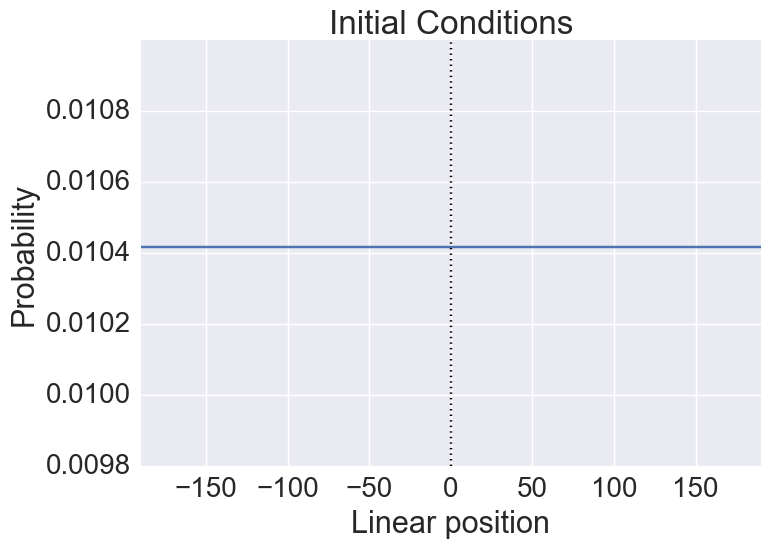

In [25]:
initial_conditions = normalize_to_probability(np.ones(linear_position_grid_centers.shape))
plt.plot(linear_position_grid_centers, initial_conditions)
plt.xlim((linear_position_grid_centers.min(), linear_position_grid_centers.max()))
plt.axvline(0, color='black', linestyle=':')
plt.xlabel('Linear position')
plt.ylabel('Probability')
plt.title('Initial Conditions')

#### State Transition Model

Need to ask about using the smoothed linear position versus not.

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


False


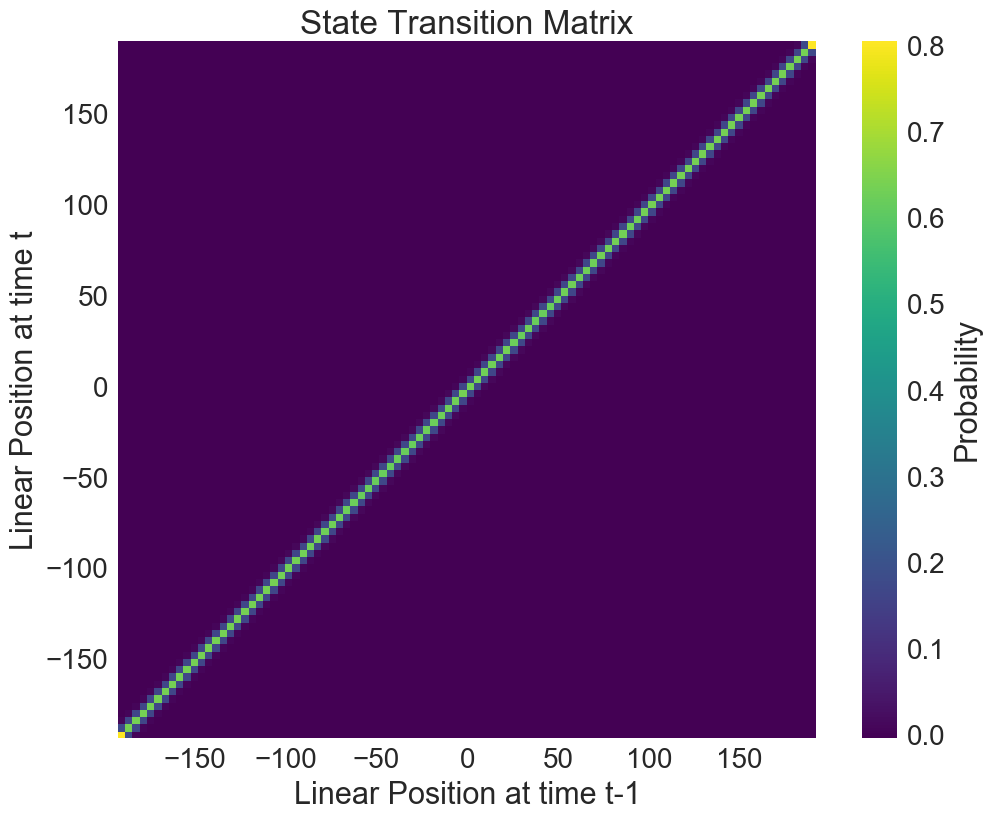

In [26]:
import scipy.ndimage.filters
linear_position_grid = np.linspace(-192, 192, 97)
state_transition, _, _ = np.histogram2d(spikes_position.linear_position.shift(-1),
                                        spikes_position.linear_position,
                                        bins=(linear_position_grid, linear_position_grid),
                                        normed=False)

# Normalize columns
state_transition = np.dot(state_transition, np.diag(1 / np.sum(state_transition, axis=0)))
# Handle zero probability bins
state_transition[:, np.sum(state_transition, axis=0) == 0] = 1 / len(linear_position_grid)
state_transition = scipy.ndimage.filters.gaussian_filter(state_transition, sigma=0.5)
# Normalize columns
state_transition = np.dot(state_transition, np.diag(1 / np.sum(state_transition, axis=0)))

print(np.all(np.sum(state_transition, axis=0) == 1))

fig, ax = plt.subplots(1, figsize=(12,9))
ax.set_title('State Transition Matrix')
x_grid, y_grid = np.meshgrid(linear_position_grid, linear_position_grid)
mesh = ax.pcolormesh(x_grid, y_grid, state_transition, cmap='viridis')
ax.set_xlim((linear_position_grid.min(), linear_position_grid.max()))
ax.set_ylim((linear_position_grid.min(), linear_position_grid.max()))
ax.set_xlabel('Linear Position at time t-1')
ax.set_ylabel('Linear Position at time t')
ax.set_aspect('equal')
plt.colorbar(mesh, label='Probability')

#### Decoding model

In [28]:
def update_posterior(prediction, likelihood):
    return normalize_to_probability(prediction * likelihood)


def predict(posterior, state_transition):
        return np.dot(state_transition, posterior)


def predict_state(data, initial_conditions=None, state_transition=None,
                    likelihood_function=None, likelihood_args={}, debug=False):
    posterior = initial_conditions
    posterior_over_time = np.zeros((data.shape[0], len(initial_conditions)))
    if debug:
        likelihood_over_time = np.zeros((data.shape[0], len(initial_conditions)))
        prior_over_time = np.zeros((data.shape[0], len(initial_conditions)))
    for time_ind in np.arange(data.shape[0]):
        # Record posterior
        posterior_over_time[time_ind, :] = posterior
        prior = predict(posterior, state_transition)
        likelihood = likelihood_function(data[time_ind, ...], **likelihood_args)
        posterior = update_posterior(prior, likelihood)
        if debug:
            likelihood_over_time[time_ind, :] = likelihood
            prior_over_time[time_ind, :] = prior
    if not debug:
        return posterior_over_time
    else:
        return posterior_over_time, likelihood_over_time, prior_over_time

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


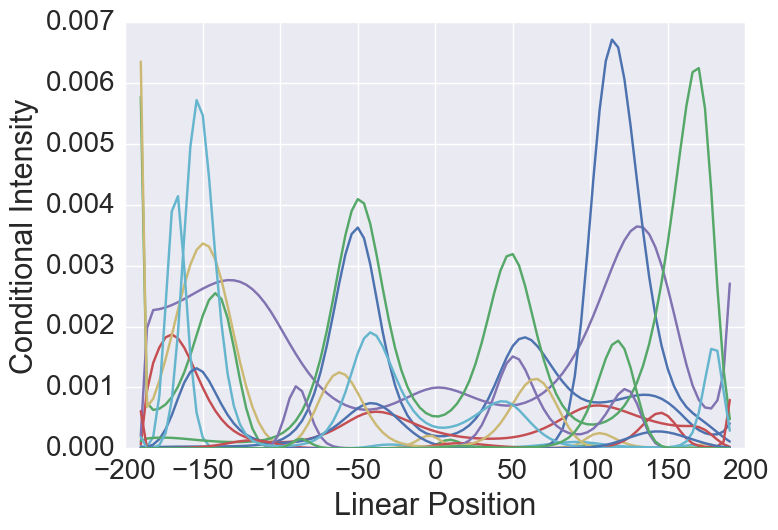

In [29]:
spikes_data = [transform_spikes(neuron_index, animals)
               for neuron_index in cur_neuron_info.index]
interpolated_positions = (pd.concat([position_categorical, interpolated_position, interpolated_position_2D], axis=1)
                          .fillna(method='backfill'))
formula = '1 + bs(linear_position, df=10, degree=3)';
design_matrix = patsy.dmatrix(formula, interpolated_positions, return_type='dataframe')

# Encode Fit on half of the data
half_data_ind = int(np.fix(len(design_matrix) / 2))

fit = [sm.GLM(neuron_spikes.iloc[0:half_data_ind], design_matrix.iloc[0:half_data_ind],
              family=sm.families.Poisson()).fit()
       for neuron_spikes in spikes_data]

# Get conditional intensity by linear position
linear_position_grid = np.linspace(-192, 192, 97)
linear_position_grid_centers = linear_position_grid[:-1] + np.diff(linear_position_grid) / 2
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info],
                                                    {'linear_position': linear_position_grid_centers})[0]
conditional_intensity = np.vstack([fitted_model.predict(predict_design_matrix)
                                   for fitted_model in fit]).T

# Get state transition
state_transition, _, _ = np.histogram2d(spikes_position.linear_position.shift(-1),
                                        spikes_position.linear_position,
                                        bins=(linear_position_grid, linear_position_grid),
                                        normed=False)

# Normalize columns
state_transition = np.dot(state_transition, np.diag(1 / np.sum(state_transition, axis=0)))
# Handle zero probability bins
state_transition[:, np.sum(state_transition, axis=0) == 0] = 1 / len(linear_position_grid)
state_transition = scipy.ndimage.filters.gaussian_filter(state_transition, sigma=0.5)
# Normalize columns
state_transition = np.dot(state_transition, np.diag(1 / np.sum(state_transition, axis=0)))

# Decode Position
likelihood_params = dict(conditional_intensity=conditional_intensity)
combined_likelihood_params = dict(likelihood_function=instantaneous_poisson_likelihood,
                                  likelihood_args=likelihood_params)
test_data = np.hstack([neuron_spikes.iloc[half_data_ind+1:].values
                       for neuron_spikes in spikes_data])
posterior_over_time, likelihood_over_time, prior_over_time = predict_state(
    test_data,
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_args=combined_likelihood_params,
    debug=True)

In [196]:
test_time = spikes_data[0].iloc[half_data_ind+1:].index
columns = pd.Index(linear_position_grid_centers, name='linear_position')
posterior_df = pd.DataFrame(posterior_over_time, index=test_time, columns=columns)
likelihood_df = pd.DataFrame(likelihood_over_time, index=test_time, columns=columns)
prior_df = pd.DataFrame(prediction_over_time, index=test_time, columns=columns)
trial_df = interpolated_positions.iloc[half_data_ind+1:]
spikes_df = pd.concat(spikes_data, axis=1, keys=cur_neuron_info.neuron_id).iloc[half_data_ind+1:]

In [332]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import functools

def filter_dataframe(dataframe_of_interest, filter_dataframe):
    original_columns = dataframe_of_interest.columns.tolist()
    return (pd.concat([dataframe_of_interest,
                      filter_dataframe], join='inner', axis=1)
            .loc[:, original_columns])

def plot_trial_density(trial_number=1, df=None, trial_df=None, spikes_df=None,
               linear_position_grid_centers=[], ax=None, label=None):
    if ax is None:
        ax = plt.gca()
    
    # Filter data
    query = 'trial_number == {trial_number}'.format(trial_number=trial_number)
    trial_df = trial_df.query(query)
    df = filter_dataframe(df, trial_df)
    spikes_df = filter_dataframe(spikes_df, trial_df)
    
    # Heatmap
    data = df.values.T
    time = df.index.values
    [time_grid, linear_position_grid] = np.meshgrid(time, linear_position_grid_centers)
    mesh = ax.pcolormesh(time_grid, linear_position_grid, data, cmap='PuRd', vmin=0, vmax=.2)
    ax.set_xlim((time.min(), time.max()))
    ax.set_ylim((linear_position_grid_centers.min() - 10, linear_position_grid_centers.max() + 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(mesh, label=label, cax=cax)
    
    # Linear Position
    ax.plot(time, trial_df.linear_position.values, alpha=0.7, label='Actual Position')
    
    # Spikes
    for neuron_name in spikes_df.columns:
        cur_spike_df = spikes_df.loc[:, [neuron_name]]
        trial_spike_df = filter_dataframe(trial_df, cur_spike_df[cur_spike_df.iloc[:, 0] > 0])
        ax.scatter(trial_spike_df.index.values,
                   trial_spike_df.linear_position.values,
                   zorder=2, color='black', s=20)

def plot_trial(cur_trial=1, trial_df=None,
               spikes_df=None, posterior_df=None,
               likelihood_df=None, linear_position_grid_centers=None):
    fig, ax = plt.subplots(3, figsize=(12,9), sharex=True, sharey=True)
    plot_trial_density(df=posterior_df,
                       trial_number=cur_trial,
                       trial_df=trial_df,
                       spikes_df=spikes_df,
                       linear_position_grid_centers=linear_position_grid_centers,
                       ax=ax[0],
                       label='Posterior Density')

    plot_trial_density(df=likelihood_df,
                       trial_number=cur_trial,
                       trial_df=trial_df,
                       spikes_df=spikes_df,
                       linear_position_grid_centers=linear_position_grid_centers,
                       ax=ax[1],
                       label='Likelihood')

    plot_trial_density(df=prior_df,
                       trial_number=cur_trial,
                       trial_df=trial_df,
                       spikes_df=spikes_df,
                       linear_position_grid_centers=linear_position_grid_centers,
                       ax=ax[2],
                       label='Prior')
    ax[-1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Linear Position')
    
plot_decoder = functools.partial(plot_trial, trial_df=trial_df,
               spikes_df=spikes_df, posterior_df=posterior_df,
               likelihood_df=likelihood_df, linear_position_grid_centers=linear_position_grid_centers)

#### Many spikes, good decoding

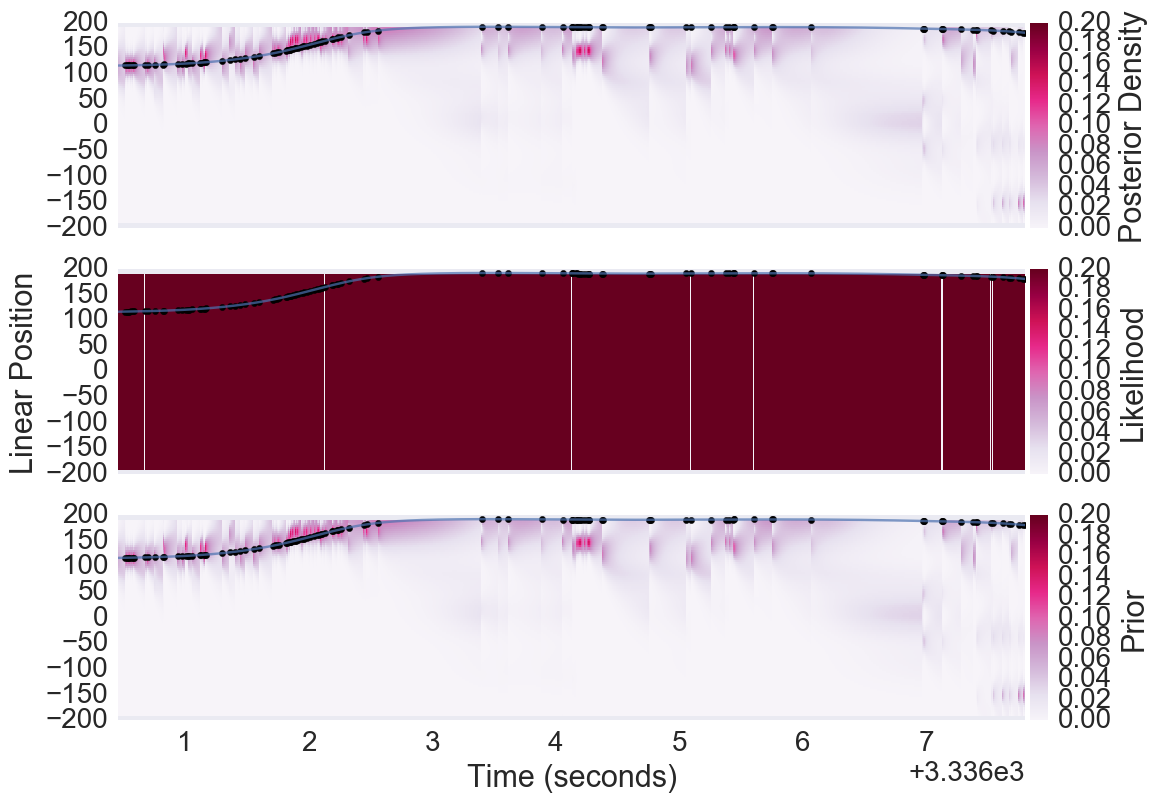

In [333]:
plot_decoder(cur_trial=305)

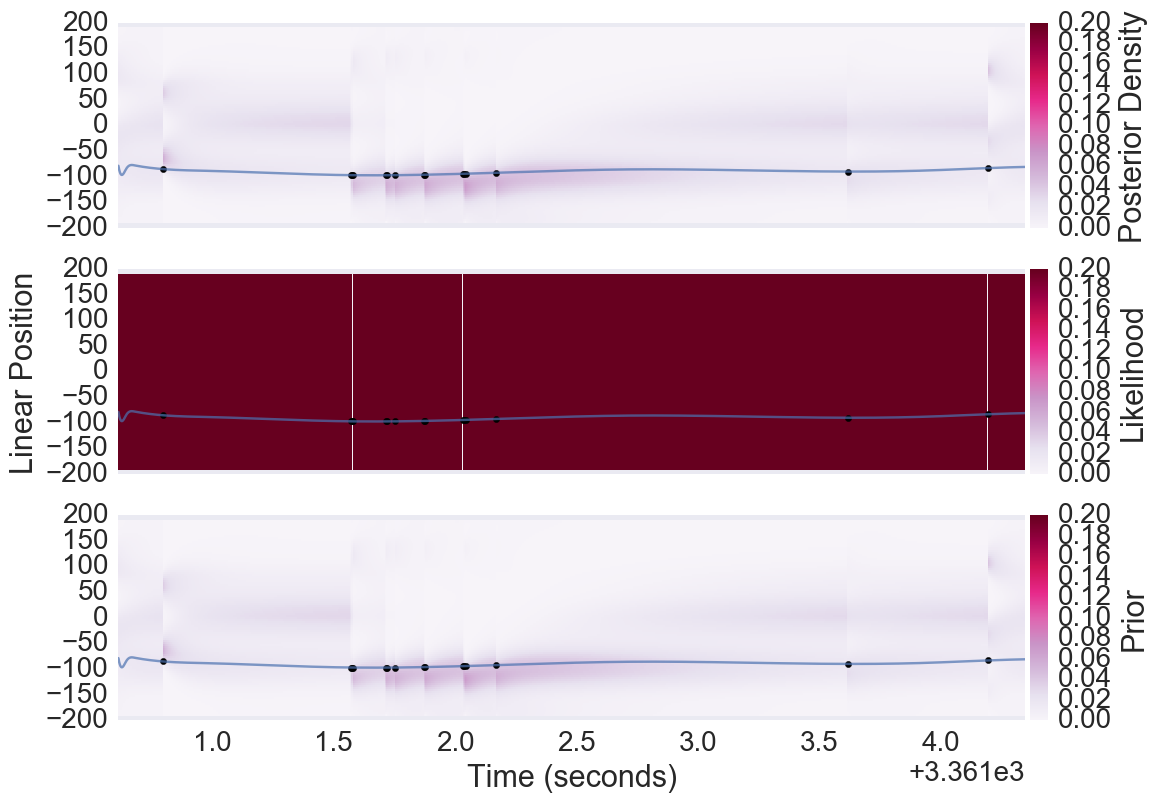

In [334]:
plot_decoder(cur_trial=314)

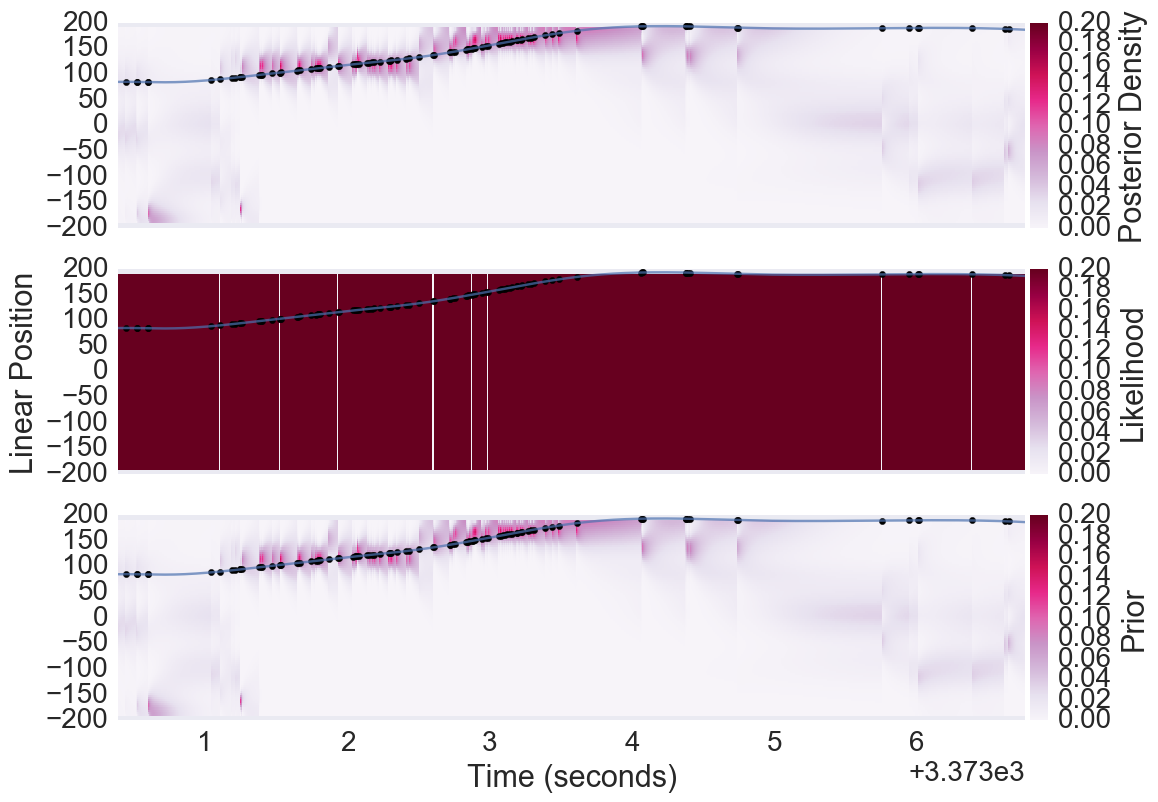

In [335]:
plot_decoder(cur_trial=330)

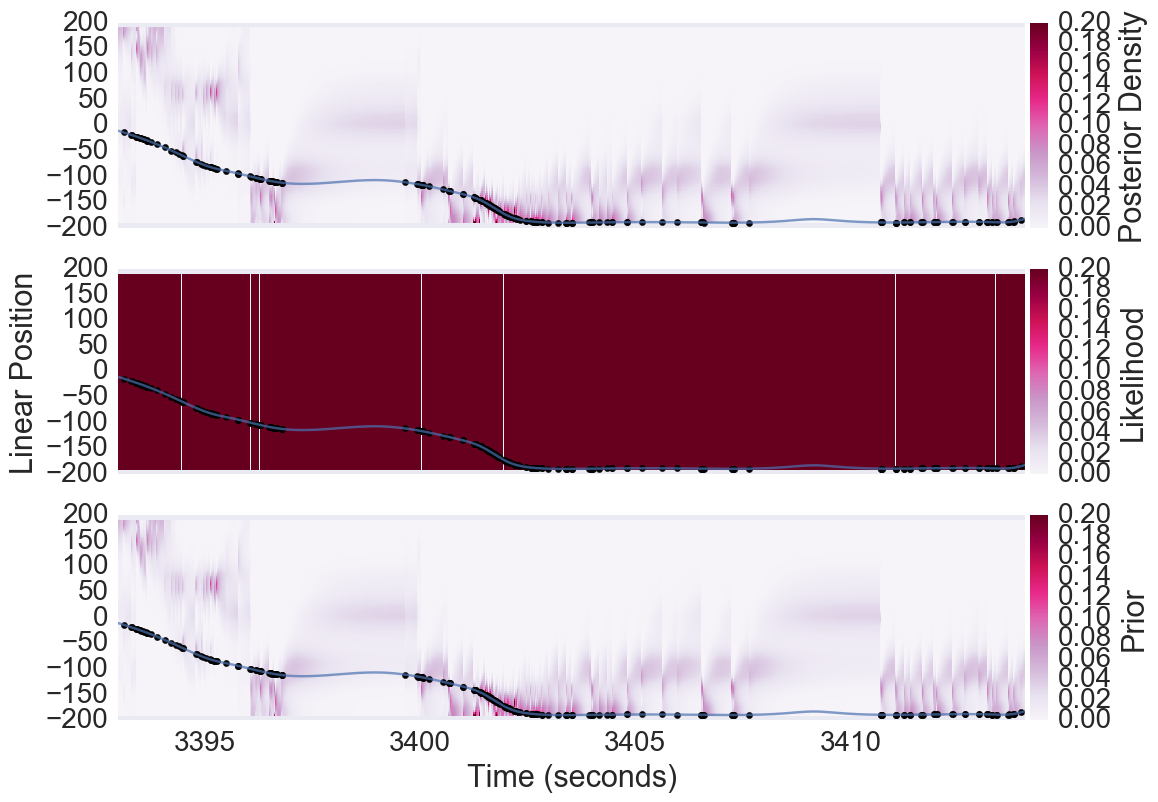

In [336]:
plot_decoder(cur_trial=335)

#### No Spike

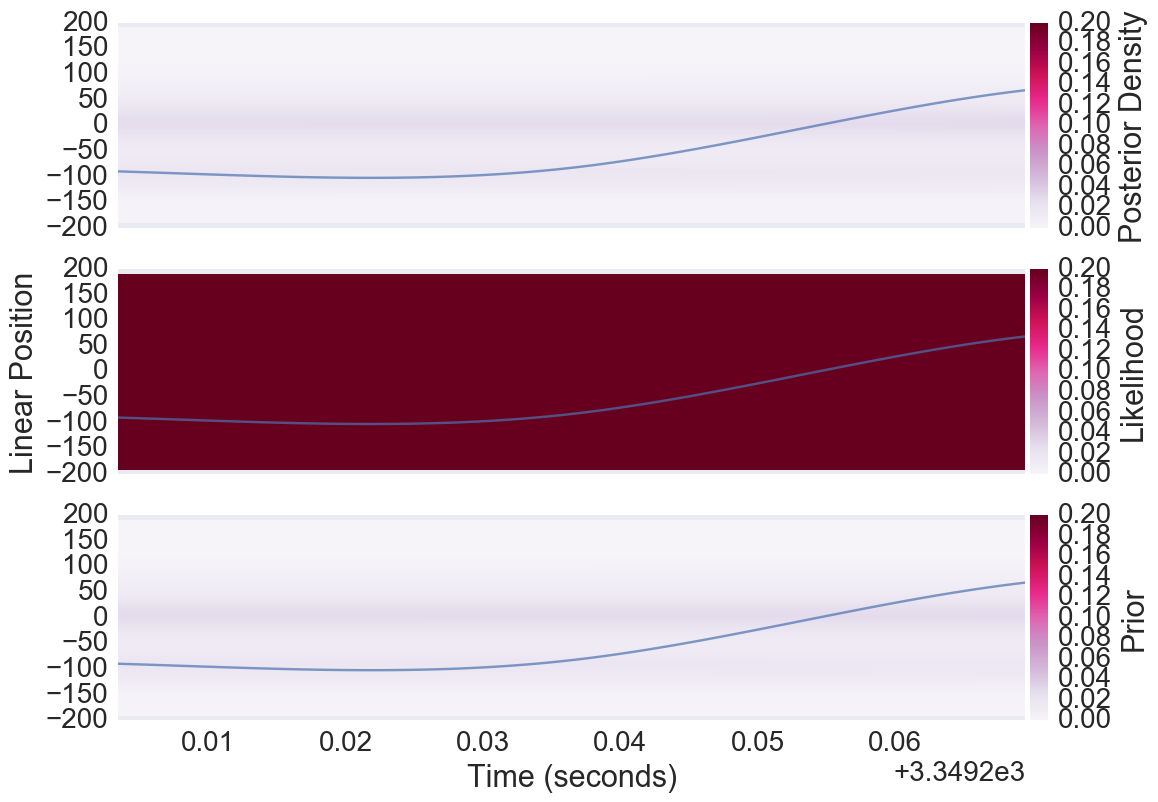

In [337]:
plot_decoder(cur_trial=308)

#### Jumping Around

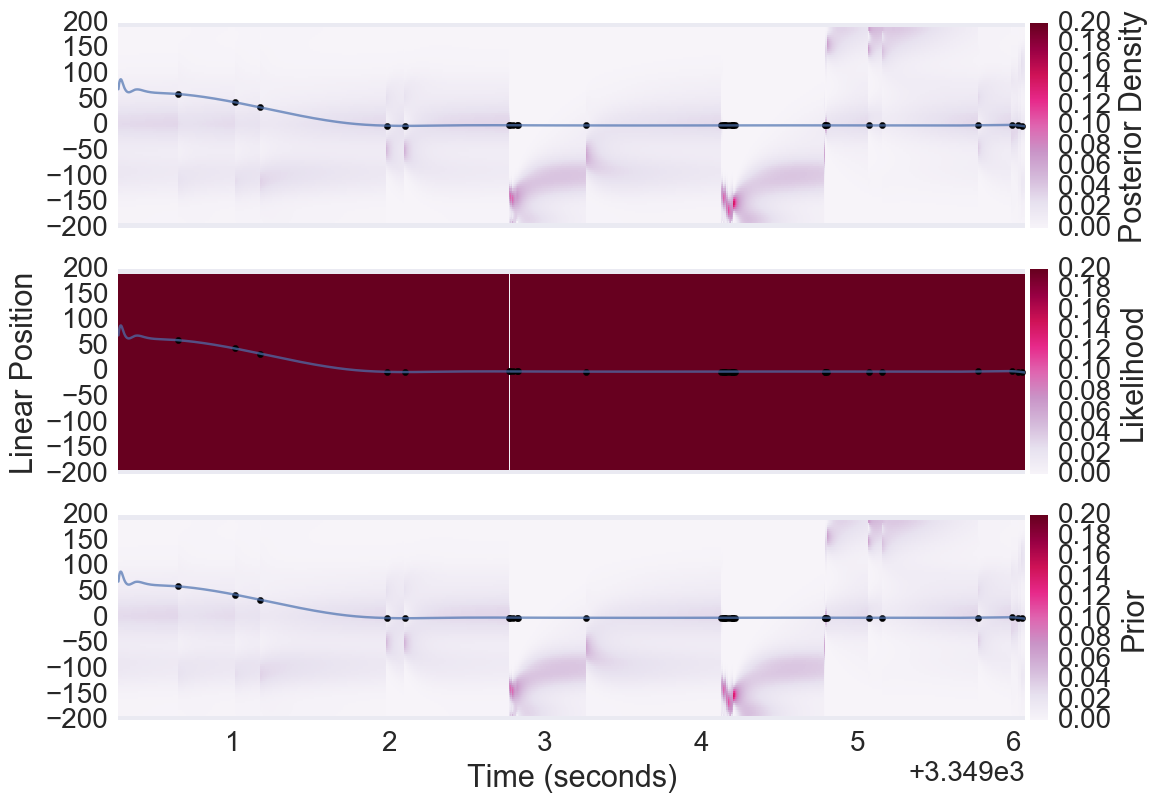

In [339]:
plot_decoder(cur_trial=309)

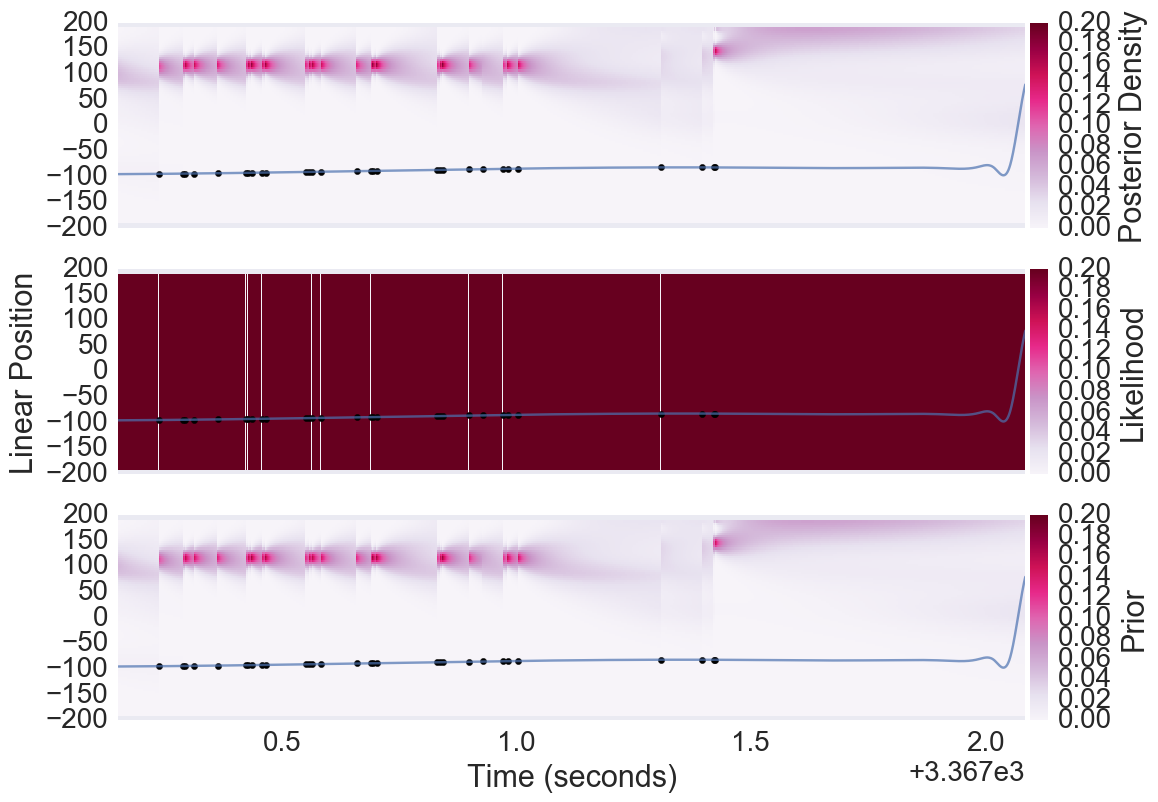

In [340]:
plot_decoder(cur_trial=317)

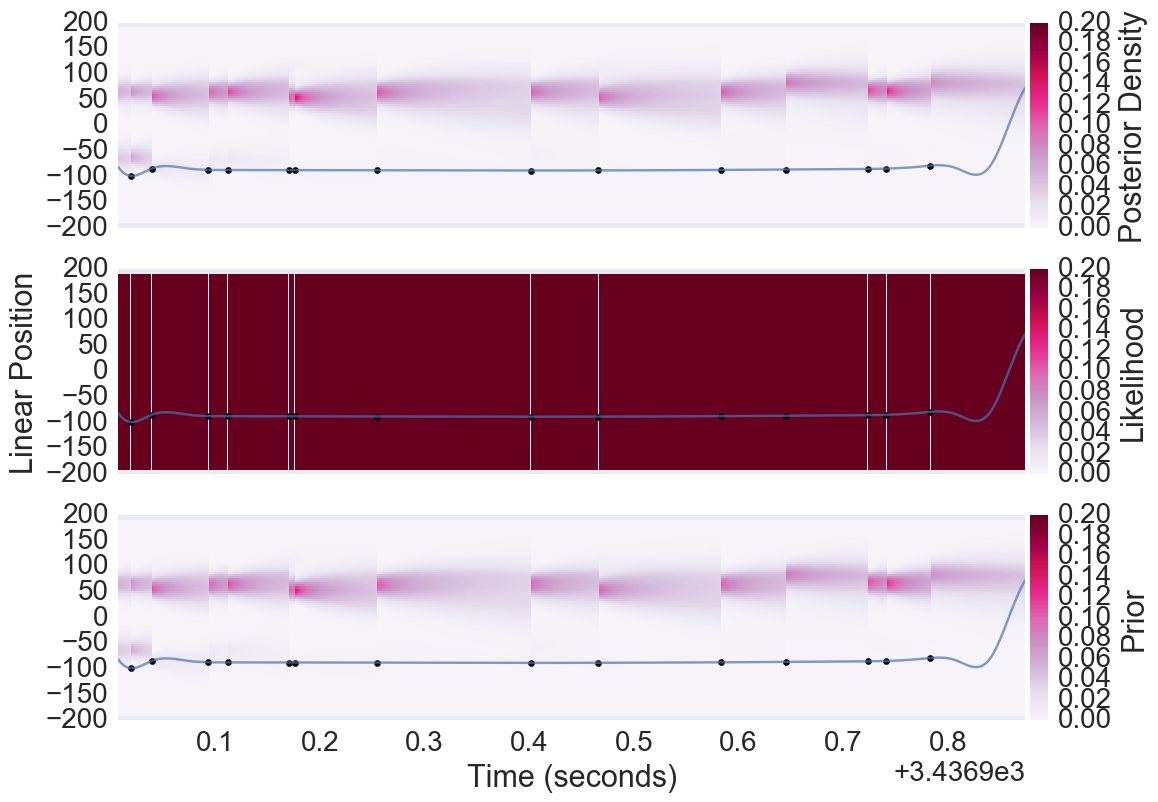

In [341]:
plot_decoder(cur_trial=360)

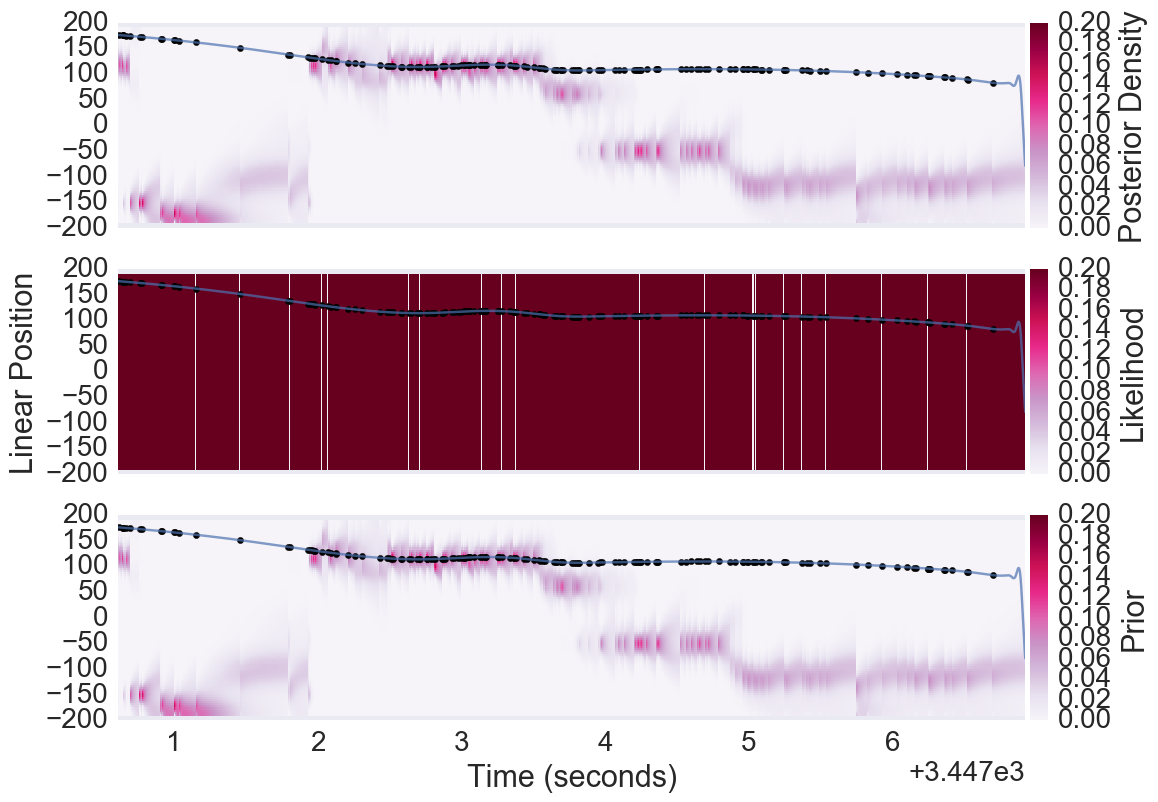

In [342]:
plot_decoder(cur_trial=370)